<a href="https://colab.research.google.com/github/sunmoan/AIFFEL_quest_rs/blob/main/quest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 74.2 MB/s eta 0:00:00


In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 34.2 MB/s eta 0:00:00


In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import FastText  # ★ Word2Vec 대신 FastText 사용
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns

import gensim, sklearn, konlpy
print("gensim:", gensim.__version__)
print("sklearn:", sklearn.__version__)
print("konlpy:", konlpy.__version__)


gensim: 4.4.0
sklearn: 1.6.1
konlpy: 0.6.0


In [ ]:
import os

zip_path = "/content/synopsis.zip"  # 업로드된 zip 파일의 절대경로
data_dir = "/content/weat/data"     # 원하는 저장 폴더

os.makedirs(data_dir, exist_ok=True)

if os.path.exists(zip_path):
    !unzip -o "$zip_path" -d "$data_dir"
else:
    print("zip 파일 없음")


Archive:  /content/synopsis.zip
  inflating: /content/weat/data/synopsis.txt  
  inflating: /content/weat/data/synopsis_SF.txt  
  inflating: /content/weat/data/synopsis_action.txt  
  inflating: /content/weat/data/synopsis_adult.txt  
  inflating: /content/weat/data/synopsis_adventure.txt  
  inflating: /content/weat/data/synopsis_animation.txt  
  inflating: /content/weat/data/synopsis_art.txt  
  inflating: /content/weat/data/synopsis_comedy.txt  
  inflating: /content/weat/data/synopsis_crime.txt  
  inflating: /content/weat/data/synopsis_documentary.txt  
  inflating: /content/weat/data/synopsis_drama.txt  
  inflating: /content/weat/data/synopsis_etc.txt  
  inflating: /content/weat/data/synopsis_family.txt  
  inflating: /content/weat/data/synopsis_fantasy.txt  
  inflating: /content/weat/data/synopsis_gen.txt  
  inflating: /content/weat/data/synopsis_historical.txt  
  inflating: /content/weat/data/synopsis_horror.txt  
  inflating: /content/weat/data/synopsis_musical.txt  
  

In [ ]:
import pandas as pd

STOPWORDS = ['의','가','이','은','들','는','좀','잘','걍','과','도','를',
             '으로','자','에','와','한','하다']

SPELLING_DICT = {
    '굳': ['궅', '굳', '굿'],
    '미쳤': ['미첫', '미쳣', '미첬', '미쳤', 'ㅁㅊ'],
    '괜찮': ['괜찮', '괜춘', '괜찬', 'ㄱㅊ', '갠찬', '갠찮', '괸찬', '괸찮'],
    '봤': ['봣'],
    '겠': ['겟']
}

def preprocess_text(text: str) -> str:
    if pd.isna(text):
        return ""

    text = str(text)
    text = re.sub(r'([.!?…;])\1+', r'\1', text)

    for correct, variations in SPELLING_DICT.items():
        for variant in variations:
            text = text.replace(variant, correct)

    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'[ㄱ-ㅎㅏ-ㅣ]+', ' ', text)
    text = re.sub(r'[^가-힣a-zA-Z0-9\s.!?,]', ' ', text)
    text = re.sub(r'([.!?,])', r' \1 ', text)
    text = text.lower()

    words = text.split()
    filtered_words = []

    for word in words:
        if word in STOPWORDS:
            continue
        found = False
        for stopword in sorted(STOPWORDS, key=len, reverse=True):
            if len(word) > len(stopword) and word.endswith(stopword):
                cleaned = word[:-len(stopword)]
                if len(cleaned) >= 2:
                    filtered_words.append(cleaned)
                    found = True
                    break
        if not found:
            filtered_words.append(word)

    text = ' '.join(filtered_words)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [ ]:
okt = Okt()
file_name = os.path.join(data_dir, "synopsis.txt")

tokenized = []
with open(file_name, 'r') as file:
    while True:
        line = file.readline()
        if not line:
            break

        # 필요하면 line = preprocess_text(line)를 여기서 적용 가능
        words = okt.pos(line, stem=True, norm=True)
        nouns = [w[0] for w in words if w[1] == "Noun"]

        if nouns:
            tokenized.append(nouns)

print("총 문장 수:", len(tokenized))
print("첫 문장 토큰 예시:", tokenized[0][:20])


총 문장 수: 70683
첫 문장 토큰 예시: ['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분']


In [ ]:
# FastText 학습
# 한국어처럼 형태가 많이 변하는 언어에서 FastText가 Word2Vec보다 OOV 처리에 유리하다.

ft_model = FastText(
    sentences=tokenized,
    vector_size=100,
    window=5,
    min_count=3,
    sg=0,          # CBOW. sg=1이면 skipgram
    workers=4,
    min_n=3,       # 서브워드 최소 n
    max_n=6        # 서브워드 최대 n
)

wv = ft_model.wv
print("단어 수:", len(wv))
print("벡터 차원:", wv.vector_size)

for word in ["영화", "사랑", "전쟁", "가족"]:
    if word in wv:
        print(f"\n'{word}'와 유사한 단어:")
        print(wv.most_similar(word)[:10])
    else:
        print(f"'{word}'는 vocabulary에 없음")


단어 수: 24320
벡터 차원: 100

'영화'와 유사한 단어:
[('실사영화', 0.9214929938316345), ('작품', 0.9130333065986633), ('청춘영화', 0.9092813730239868), ('영화로', 0.9018020629882812), ('민영화', 0.8974735140800476), ('영화관', 0.8929889798164368), ('영화인', 0.8917752504348755), ('극영화', 0.8845441937446594), ('기록영화', 0.8809061050415039), ('가족영화', 0.8743599653244019)]

'사랑'와 유사한 단어:
[('청구', 0.9751489162445068), ('사랑방', 0.9740185141563416), ('풋사랑', 0.9231204986572266), ('옛사랑', 0.9111508727073669), ('첫사랑', 0.7973869442939758), ('애정', 0.7312512397766113), ('이별', 0.7271140217781067), ('연애', 0.7248374223709106), ('진심', 0.7185369729995728), ('행복', 0.7141240835189819)]

'전쟁'와 유사한 단어:
[('전쟁기', 0.9867262244224548), ('핵전쟁', 0.9575546383857727), ('중일전쟁', 0.908338725566864), ('남북전쟁', 0.8793152570724487), ('전쟁범죄', 0.8769803643226624), ('우주전쟁', 0.8548241257667542), ('미래세', 0.8466206192970276), ('생존', 0.8178962469100952), ('생존권', 0.809585452079773), ('팔레스타인인', 0.786257803440094)]

'가족'와 유사한 단어:
[('대가족', 0.8426369428634644), ('유가족', 0.7945

In [ ]:
def read_token(file_name: str) -> str:
    okt = Okt()
    result = []
    path = os.path.join(data_dir, file_name)
    print(file_name, "파일을 읽는 중...")

    with open(path, 'r') as fread:
        while True:
            line = fread.readline()
            if not line:
                break
            # 필요하면 line = preprocess_text(line)
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word, pos in tokenlist:
                if pos == "Noun":
                    result.append(word)
    return ' '.join(result)


In [ ]:
art_txt = "synopsis_art.txt"
gen_txt = "synopsis_gen.txt"

art_text = read_token(art_txt)
gen_text = read_token(gen_txt)

vectorizer_type = TfidfVectorizer()
X_type = vectorizer_type.fit_transform([art_text, gen_text])  # 2 x vocab
print("X_type shape:", X_type.shape)

m_art = X_type[0].tocoo()
m_gen = X_type[1].tocoo()

w_art = [[i, v] for i, v in zip(m_art.col, m_art.data)]
w_gen = [[i, v] for i, v in zip(m_gen.col, m_gen.data)]

w_art.sort(key=lambda x: x[1], reverse=True)
w_gen.sort(key=lambda x: x[1], reverse=True)

vocab_type = vectorizer_type.get_feature_names_out()

top_k = 100
cand_art = [vocab_type[w_art[i][0]] for i in range(min(top_k, len(w_art)))]
cand_gen = [vocab_type[w_gen[i][0]] for i in range(min(top_k, len(w_gen)))]

n_attr = 15
attr_art, attr_gen = [], []

for word in cand_art:
    if word not in cand_gen and word in wv:
        attr_art.append(word)
    if len(attr_art) == n_attr:
        break

for word in cand_gen:
    if word not in cand_art and word in wv:
        attr_gen.append(word)
    if len(attr_gen) == n_attr:
        break

print("\n예술영화를 대표하는 단어들 (Attribute A):")
print(attr_art)

print("\n상업영화를 대표하는 단어들 (Attribute B):")
print(attr_gen)


synopsis_art.txt 파일을 읽는 중...
synopsis_gen.txt 파일을 읽는 중...
X_type shape: (2, 41082)

예술영화를 대표하는 단어들 (Attribute A):
['아빠', '음악', '운명', '결심', '지금', '여인', '이름', '이후', '준비', '만난', '감정', '처음', '누구', '충격', '그린']

상업영화를 대표하는 단어들 (Attribute B):
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [ ]:
genre_txt = [
    "synopsis_action.txt",
    "synopsis_adult.txt",
    "synopsis_adventure.txt",
    "synopsis_animation.txt",
    "synopsis_comedy.txt",
    "synopsis_crime.txt",
    "synopsis_documentary.txt",
    "synopsis_drama.txt",
    "synopsis_etc.txt",
    "synopsis_family.txt",
    "synopsis_fantasy.txt",
    "synopsis_historical.txt",
    "synopsis_horror.txt",
    "synopsis_musical.txt",
    "synopsis_mystery.txt",
    "synopsis_romance.txt",
    "synopsis_SF.txt",
    "synopsis_show.txt",
    "synopsis_thriller.txt",
    "synopsis_war.txt",
    "synopsis_western.txt"
]

genre_name = [
    "Action",
    "Adult",
    "Adventure",
    "Animation",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Etc",
    "Family",
    "Fantasy",
    "Historical",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "SF",
    "Show",
    "Thriller",
    "War",
    "Western"
]


print("장르 개수:", len(genre_txt))


장르 개수: 21


In [ ]:
genre_texts = []
for file_name in genre_txt:
    text = read_token(file_name)
    genre_texts.append(text)

print("장르 텍스트 개수:", len(genre_texts))


synopsis_action.txt 파일을 읽는 중...
synopsis_adult.txt 파일을 읽는 중...
synopsis_adventure.txt 파일을 읽는 중...
synopsis_animation.txt 파일을 읽는 중...
synopsis_comedy.txt 파일을 읽는 중...
synopsis_crime.txt 파일을 읽는 중...
synopsis_documentary.txt 파일을 읽는 중...
synopsis_drama.txt 파일을 읽는 중...
synopsis_etc.txt 파일을 읽는 중...
synopsis_family.txt 파일을 읽는 중...
synopsis_fantasy.txt 파일을 읽는 중...
synopsis_historical.txt 파일을 읽는 중...
synopsis_horror.txt 파일을 읽는 중...
synopsis_musical.txt 파일을 읽는 중...
synopsis_mystery.txt 파일을 읽는 중...
synopsis_romance.txt 파일을 읽는 중...
synopsis_SF.txt 파일을 읽는 중...
synopsis_show.txt 파일을 읽는 중...
synopsis_thriller.txt 파일을 읽는 중...
synopsis_war.txt 파일을 읽는 중...
synopsis_western.txt 파일을 읽는 중...
장르 텍스트 개수: 21


In [ ]:
vectorizer_genre = TfidfVectorizer()
X_genre = vectorizer_genre.fit_transform(genre_texts)
print("X_genre shape:", X_genre.shape)

vocab_genre = vectorizer_genre.get_feature_names_out()

df = np.asarray((X_genre > 0).sum(axis=0)).ravel()
print("vocab size:", len(df))


X_genre shape: (21, 42191)
vocab size: 42191


In [27]:
n_target = 30
max_df = 5   # 이 값보다 많은 장르에 등장하는 단어는 제외

m_list = [X_genre[i].tocoo() for i in range(X_genre.shape[0])]
genre_targets = []

for gi in range(len(genre_name)):
    m = m_list[gi]
    w = [[i, v] for i, v in zip(m.col, m.data)]
    w.sort(key=lambda x: x[1], reverse=True)

    selected = []
    for idx, val in w:
        word = vocab_genre[idx]
        if word in wv and df[idx] <= max_df:
            selected.append(word)
        if len(selected) == n_target:
            break

    genre_targets.append(selected)

for name, words in zip(genre_name, genre_targets):
    print(f"{name} 대표 단어 ({len(words)}개):")
    print(words)
    print()


Action 대표 단어 (30개):
['패트레이버', '강호', '아틸라', '괴도', '무에타이', '배너', '비취', '장청', '인터폴', '청나라', '핵폭탄', '베켓', '정성공', '포두', '사만사', '안젤로', '스바루', '야마카시', '벤허', '소림사', '무공', '블레이드', '체이스', '암흑가', '정보원', '메갈로돈', '최배달', '흥숙', '신선', '어윈']

Adult 대표 단어 (30개):
['욕구불만', '카즈야', '애무', '타케시', '사유리', '파친코', '이쿠', '카오리', '쿄코', '다이스케', '아츠시', '케이코', '이사오', '마유', '시호', '미쿠', '아야카', '의붓아들', '사촌누나', '오오시마', '미와코', '미치루', '아키코', '타쿠야', '신야', '야마토', '아유미', '와카', '리호', '루오']

Adventure 대표 단어 (30개):
['앤트', '옥자', '윈치', '펠레', '크루소', '양말', '썰매개', '루거', '윈치그룹', '파비', '프리몬트', '하니프', '알라딘', '십자군', '국새', '누크', '슈퍼악당', '아킬레스', '다릭', '대븐포트', '리아쯔', '에레보스', '오셀롯', '투탕', '석판', '주교', '사바', '안젤로', '정거장', '코로나']

Animation 대표 단어 (30개):
['인디애니페스트', '도롱', '퍼니퍼', '고고', '코리아', '임팩트', '곰퉁', '뽀로로', '생쥐', '나루토', '스톱모션', '포켓몬', '카이바', '코난', '안시', '병아리', '코코', '다람쥐', '불찰', '시소', '리쿠', '스머프', '로켓', '독수리', '로보트', '장난꾸러기', '짱구', '도토리', '애벌레', '얼룩말']

Comedy 대표 단어 (30개):
['삼순', '진헌', '퍼프', '티탕', '캘빈', '핀치', '사브리나', '킹카', '준꼬', '철곤', '가필드', '

[1트]
Action 대표 단어 (15개):
['패트레이버', '강호', '아틸라', '괴도', '무에타이', '배너', '비취', '장청', '인터폴', '청나라', '핵폭탄', '베켓', '정성공', '포두', '사만사']

Adult 대표 단어 (15개):
['욕구불만', '카즈야', '애무', '타케시', '사유리', '파친코', '이쿠', '카오리', '쿄코', '다이스케', '아츠시', '케이코', '이사오', '마유', '시호']

Adventure 대표 단어 (15개):
['앤트', '옥자', '윈치', '펠레', '크루소', '양말', '썰매개', '루거', '윈치그룹', '파비', '프리몬트', '하니프', '알라딘', '십자군', '국새']

Animation 대표 단어 (15개):
['인디애니페스트', '도롱', '퍼니퍼', '고고', '코리아', '임팩트', '곰퉁', '뽀로로', '생쥐', '나루토', '스톱모션', '포켓몬', '카이바', '코난', '안시']

Comedy 대표 단어 (15개):
['삼순', '진헌', '퍼프', '티탕', '캘빈', '핀치', '사브리나', '킹카', '준꼬', '철곤', '가필드', '만수', '현준', '슈티', '마가리타']

Crime 대표 단어 (15개):
['한길수', '파푸아', '마샨', '철중', '맥베드', '샤오창', '와처스', '카시우스', '몬티', '고다', '미결', '베네딕트', '일영', '태주', '오션']

Documentary 대표 단어 (15개):
['인디다큐페스티발', '인권영화제', '건축사', '세월호', '농성', '성소수자', '비보이', '라이머', '활동가', '기후변화', '선교사', '민주주의', '김기덕', '조선족', '지라니']

Drama 대표 단어 (15개):
['선호', '쿄코', '수민', '민아', '우민', '경수', '미숙', '명주', '케코', '은수', '정호', '앵글', '루벤', '만수', '간첩']

Etc 대표 단어 (15개):
['메트로', '독도', '완섭', '준희', '발달장애', '에르나니', '연유', '우석', '진욱', '숙희', '세르지뉴', '아도니스', '참프루', '페소아', '나뭇잎']

Family 대표 단어 (15개):
['아주르', '낙타', '씨제이', '동구', '슈이트', '마갈', '펠리칸', '벤트', '최호', '혜지', '파코', '누키', '크누드', '제노', '주니']

Fantasy 대표 단어 (15개):
['순영', '남보라', '차사', '니모', '원풍', '덤블도어', '나서스', '바버라', '얌마', '삼장법사', '도둑고양이', '디거', '마법부', '양쟈린', '자홍']

Historical 대표 단어 (15개):
['신기전', '아가멤논', '루안', '하선', '윤서', '노준', '세자', '신재효', '채선', '허균', '히파티아', '아킬레스', '양반', '광해군', '브리튼']

Horror 대표 단어 (15개):
['분홍신', '레스태트', '본즈', '프롱삭', '사마귀', '에스터', '부기맨', '아스왕', '엑소시즘', '데이나', '엘런', '퇴마사', '던칸', '핼러윈', '누알']

Musical 대표 단어 (15개):
['에스메랄다', '토스카', '니웨', '페뷔스', '프롤', '모도', '카르피', '샤오캉', '제루샤', '데이비', '팬텀', '노트르담', '라훌', '캬바레', '안젤로']

Mystery 대표 단어 (15개):
['방독면', '랭던', '몰카', '거미숲', '종섭', '동식', '승호', '민수현', '그윈플렌', '샤오싱', '시엘', '한준', '헬마', '미리엄', '도경']

Romance 대표 단어 (15개):
['미연', '준석', '스와핑', '준영', '미란', '치한', '석호', '동수', '경수', '민정', '동욱', '나오키', '재훈', '혁수', '인혜']

SF 대표 단어 (15개):
['리플리', '켈빈', '컨트', '수퍼맨', '분파', '히노키', '섹터', '토네이도', '강두', '라임', '에일리언', '치티', '미노스', '영건', '마토']

Show 대표 단어 (15개):
['토스카', '올레', '오텔로', '리골레토', '베르디', '비바', '카르피', '백작부인', '아리아', '차이코프스키', '라다', '메스', '파우스트', '만토바', '코락스']

Thriller 대표 단어 (15개):
['영훈', '혜영', '탤리', '트래셔', '명훈', '성열', '이하연', '콘로', '비숍', '슬레븐', '정호', '로마노', '린란', '샤오신', '슈라더']

War 대표 단어 (15개):
['윈터스', '이지중대', '혁리', '동막골', '나폴레옹', '소련군', '고구려', '러시아군', '갈리폴리', '라핀', '전투기', '상륙작전', '아군', '전방', '공중전']

Western 대표 단어 (15개):
['벌린', '그레이프바인', '개릿', '에머슨', '마적', '태구', '랜던', '버질', '교수형', '듀발', '만도', '장고', '니트로', '론섬', '박창']

[2트]
Action 대표 단어 (30개):
['패트레이버', '강호', '아틸라', '괴도', '무에타이', '배너', '비취', '장청', '인터폴', '청나라', '핵폭탄', '베켓', '정성공', '포두', '사만사', '안젤로', '스바루', '야마카시', '벤허', '소림사', '무공', '블레이드', '체이스', '암흑가', '정보원', '메갈로돈', '최배달', '흥숙', '신선', '어윈']

Adult 대표 단어 (30개):
['욕구불만', '카즈야', '애무', '타케시', '사유리', '파친코', '이쿠', '카오리', '쿄코', '다이스케', '아츠시', '케이코', '이사오', '마유', '시호', '미쿠', '아야카', '의붓아들', '사촌누나', '오오시마', '미와코', '미치루', '아키코', '타쿠야', '신야', '야마토', '아유미', '와카', '리호', '루오']

Adventure 대표 단어 (30개):
['앤트', '옥자', '윈치', '펠레', '크루소', '양말', '썰매개', '루거', '윈치그룹', '파비', '프리몬트', '하니프', '알라딘', '십자군', '국새', '누크', '슈퍼악당', '아킬레스', '다릭', '대븐포트', '리아쯔', '에레보스', '오셀롯', '투탕', '석판', '주교', '사바', '안젤로', '정거장', '코로나']

Animation 대표 단어 (30개):
['인디애니페스트', '도롱', '퍼니퍼', '고고', '코리아', '임팩트', '곰퉁', '뽀로로', '생쥐', '나루토', '스톱모션', '포켓몬', '카이바', '코난', '안시', '병아리', '코코', '다람쥐', '불찰', '시소', '리쿠', '스머프', '로켓', '독수리', '로보트', '장난꾸러기', '짱구', '도토리', '애벌레', '얼룩말']

Comedy 대표 단어 (30개):
['삼순', '진헌', '퍼프', '티탕', '캘빈', '핀치', '사브리나', '킹카', '준꼬', '철곤', '가필드', '만수', '현준', '슈티', '마가리타', '석태', '렉터', '라파엘', '영규', '하루히', '병구', '총각', '세릉', '웡카', '케네스', '샬린', '치어리더', '정주', '정환', '봉구']

Crime 대표 단어 (30개):
['한길수', '파푸아', '마샨', '철중', '맥베드', '샤오창', '와처스', '카시우스', '몬티', '고다', '미결', '베네딕트', '일영', '태주', '오션', '미네르바', '오르테가', '이성호', '민하', '인선', '범죄수사', '앙트완', '니틀스', '부르투스', '송진밍', '유안펭밍', '토포', '방제', '미진', '배심원']

Documentary 대표 단어 (30개):
['인디다큐페스티발', '인권영화제', '건축사', '세월호', '농성', '성소수자', '비보이', '라이머', '활동가', '기후변화', '선교사', '민주주의', '김기덕', '조선족', '지라니', '항쟁', '탈북자', '캄보디아', '내레이션', '위안부', '성노동자', '페미니즘', '후쿠시마', '네팔', '아카이브', '옥한흠', '국립공원', '미얀마', '유가족', '평양']

Drama 대표 단어 (30개):
['선호', '쿄코', '수민', '민아', '우민', '경수', '미숙', '명주', '케코', '은수', '정호', '앵글', '루벤', '만수', '간첩', '면회', '미자', '민정', '성현', '웬디', '토코', '소냐', '영화아카데미', '조선족', '희진', '영남', '인권영화제', '탈북자', '동호', '경희']

Etc 대표 단어 (30개):
['메트로', '독도', '완섭', '준희', '발달장애', '에르나니', '연유', '우석', '진욱', '숙희', '세르지뉴', '아도니스', '참프루', '페소아', '나뭇잎', '아야카', '재우', '인권영화제', '텍스트', '벨린다', '이희', '무형', '희진', '루하시', '송재', '지서', '초달', '경식', '공중전화', '용준']

Family 대표 단어 (30개):
['아주르', '낙타', '씨제이', '동구', '슈이트', '마갈', '펠리칸', '벤트', '최호', '혜지', '파코', '누키', '크누드', '제노', '주니', '규완', '신차', '잉그릿', '제페토', '수아', '스케이팅', '스노', '양씨', '매킷', '볼러스', '블리자드', '스위드', '콜랴', '크시', '젤다']

Fantasy 대표 단어 (30개):
['순영', '남보라', '차사', '니모', '원풍', '덤블도어', '나서스', '바버라', '얌마', '삼장법사', '도둑고양이', '디거', '마법부', '양쟈린', '자홍', '주씨', '집신', '키산', '탁일항', '홀터', '효렴', '야구모', '아델라', '윈체스터', '이디스', '이랜드', '손오공', '파르', '가영은', '메두사']

Historical 대표 단어 (30개):
['신기전', '아가멤논', '루안', '하선', '윤서', '노준', '세자', '신재효', '채선', '허균', '히파티아', '아킬레스', '양반', '광해군', '브리튼', '독립군', '광헌', '윤복', '임숭재', '김민', '청나라', '공진', '관상', '영조', '조혁', '팔도', '흥부', '포수', '김정호', '만덕']

Horror 대표 단어 (30개):
['분홍신', '레스태트', '본즈', '프롱삭', '사마귀', '에스터', '부기맨', '아스왕', '엑소시즘', '데이나', '엘런', '퇴마사', '던칸', '핼러윈', '누알', '패너', '웬디', '슬래셔', '아야카', '캘리', '그레텔', '영매', '다크니스', '머시', '빈젠트', '아키바', '혜화', '빅풋', '스콜피온', '할로우']

Musical 대표 단어 (30개):
['에스메랄다', '토스카', '니웨', '페뷔스', '프롤', '모도', '카르피', '샤오캉', '제루샤', '데이비', '팬텀', '노트르담', '라훌', '캬바레', '안젤로', '서영은', '파두', '뮤지컬영화', '살리에리', '프롤로', '베이커', '연화', '지엔', '경민이', '솔리스트', '오강', '위그', '라프', '이지아', '수박']

Mystery 대표 단어 (30개):
['방독면', '랭던', '몰카', '거미숲', '종섭', '동식', '승호', '민수현', '그윈플렌', '샤오싱', '시엘', '한준', '헬마', '미리엄', '도경', '도로시', '류수현', '일루미나티', '자윤', '장펑', '가시와', '영식', '타마요', '광수', '태규', '맥카닉', '월령', '진홍', '가와사키', '린코']

Romance 대표 단어 (30개):
['미연', '준석', '스와핑', '준영', '미란', '치한', '석호', '동수', '경수', '민정', '동욱', '나오키', '재훈', '혁수', '인혜', '에츠코', '시동생', '은지', '쿄코', '조강', '완진', '원기', '준철', '지용', '미애', '아리사', '애란', '진아', '서연', '은미']

SF 대표 단어 (30개):
['리플리', '켈빈', '컨트', '수퍼맨', '분파', '히노키', '섹터', '토네이도', '강두', '라임', '에일리언', '치티', '미노스', '영건', '마토', '디셉티콘', '송현', '앤더', '아이언맨', '블랙옥스', '위저드', '은하계', '클라크', '플래시', '네크로몬거', '오토봇', '젠슨', '게릴라군', '써로게이트', '제브라맨']

Show 대표 단어 (30개):
['토스카', '올레', '오텔로', '리골레토', '베르디', '비바', '카르피', '백작부인', '아리아', '차이코프스키', '라다', '메스', '파우스트', '만토바', '코락스', '엘비', '로돌포', '안젤로', '총독', '톨로', '투란도트', '헤르', '에티오피아', '돈나', '레나토', '뱅쿠오', '카시오', '프로스페', '데모', '맥베스']

Thriller 대표 단어 (30개):
['영훈', '혜영', '탤리', '트래셔', '명훈', '성열', '이하연', '콘로', '비숍', '슬레븐', '정호', '로마노', '린란', '샤오신', '슈라더', '푸칫', '석현', '은미', '릴리스', '커터', '폴린', '벨렌', '래빗', '케일', '디스켓', '박덕', '이수연', '치요꼬', '탕위', '기훈']

War 대표 단어 (30개):
['윈터스', '이지중대', '혁리', '동막골', '나폴레옹', '소련군', '고구려', '러시아군', '갈리폴리', '라핀', '전투기', '상륙작전', '아군', '전방', '공중전', '중령', '올로', '평양성', '포렐', '노르망디', '다이크', '레닌그라드', '모가디슈', '버넷', '총공격', '항복', '기갑부대', '남생', '미해병대', '실미도']

Western 대표 단어 (30개):
['벌린', '그레이프바인', '개릿', '에머슨', '마적', '태구', '랜던', '버질', '교수형', '듀발', '만도', '장고', '니트로', '론섬', '박창', '와이오밍', '정길', '테일런', '플린더스', '더치', '도브', '랜슨', '바운티', '박도', '베다', '앨버커키', '풍운아', '거가', '독고', '리터']



In [28]:
from numpy.linalg import norm

def cosine_sim(u, v):
    return np.dot(u, v) / (norm(u) * norm(v) + 1e-9)

def s_wAB(w, A, B):
    return np.mean([cosine_sim(w, a) for a in A]) - np.mean([cosine_sim(w, b) for b in B])

def weat_effect_size(X, Y, A, B):
    s_X = np.array([s_wAB(x, A, B) for x in X])
    s_Y = np.array([s_wAB(y, A, B) for y in Y])

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    all_s = np.concatenate([s_X, s_Y])
    std_all = np.std(all_s) + 1e-9

    return (mean_X - mean_Y) / std_all


In [30]:
# Attribute: 예술영화(A), 상업영화(B)
A = np.array([wv[word] for word in attr_art if word in wv])
B = np.array([wv[word] for word in attr_gen if word in wv])

print("A shape:", A.shape)
print("B shape:", B.shape)

# 장르별 Target 벡터
genre_vecs = []
for words in genre_targets:
    vecs = [wv[w] for w in words if w in wv]
    genre_vecs.append(np.array(vecs))

for name, vec in zip(genre_name, genre_vecs):
    print(name, "벡터 수:", vec.shape[0])


A shape: (15, 100)
B shape: (15, 100)
Action 벡터 수: 30
Adult 벡터 수: 30
Adventure 벡터 수: 30
Animation 벡터 수: 30
Comedy 벡터 수: 30
Crime 벡터 수: 30
Documentary 벡터 수: 30
Drama 벡터 수: 30
Etc 벡터 수: 30
Family 벡터 수: 30
Fantasy 벡터 수: 30
Historical 벡터 수: 30
Horror 벡터 수: 30
Musical 벡터 수: 30
Mystery 벡터 수: 30
Romance 벡터 수: 30
SF 벡터 수: 30
Show 벡터 수: 30
Thriller 벡터 수: 30
War 벡터 수: 30
Western 벡터 수: 30


In [31]:
n_genre = len(genre_name)
matrix = np.zeros((n_genre, n_genre))

for i in range(n_genre):
    Xi = genre_vecs[i]
    if len(Xi) == 0:
        continue
    for j in range(n_genre):
        if i == j:
            continue
        Yj = genre_vecs[j]
        if len(Yj) == 0:
            continue
        score = weat_effect_size(Xi, Yj, A, B)
        matrix[i, j] = score

print("WEAT matrix shape:", matrix.shape)


WEAT matrix shape: (21, 21)


In [32]:
!apt-get update -qq
!apt-get install -qq fonts-nanum

import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


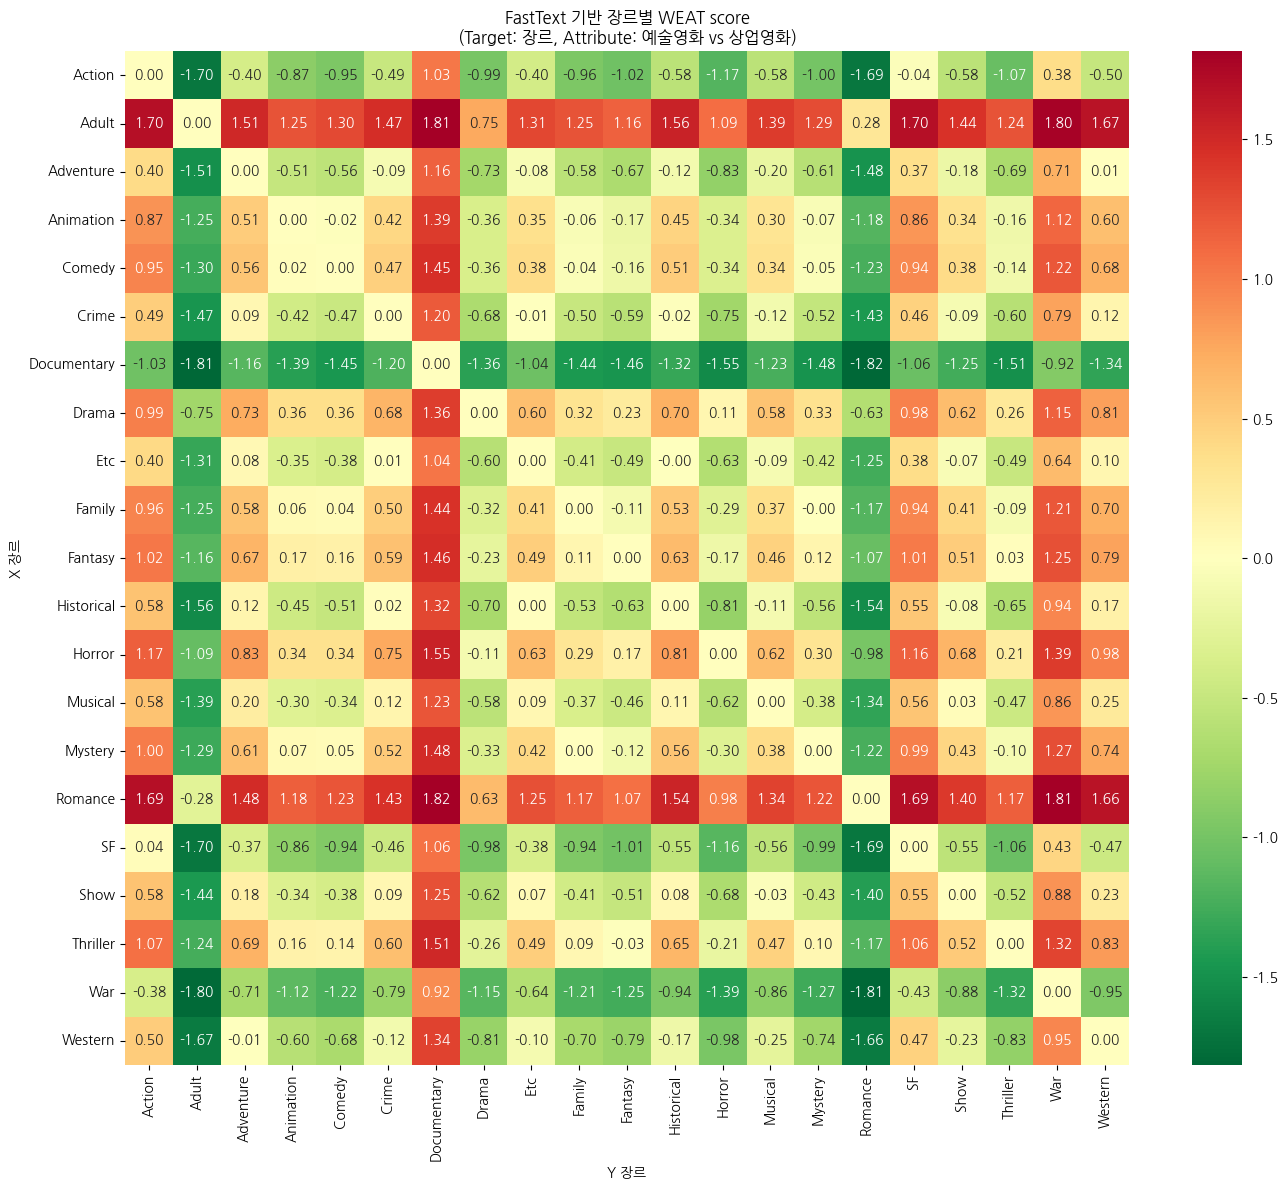

In [33]:
plt.figure(figsize=(14, 12))

ax = sns.heatmap(
    matrix,
    xticklabels=genre_name,
    yticklabels=genre_name,
    annot=True,
    fmt=".2f",
    cmap='RdYlGn_r',
    center=0
)

plt.title("FastText 기반 장르별 WEAT score\n(Target: 장르, Attribute: 예술영화 vs 상업영화)")
plt.xlabel("Y 장르")
plt.ylabel("X 장르")
plt.tight_layout()
plt.show()


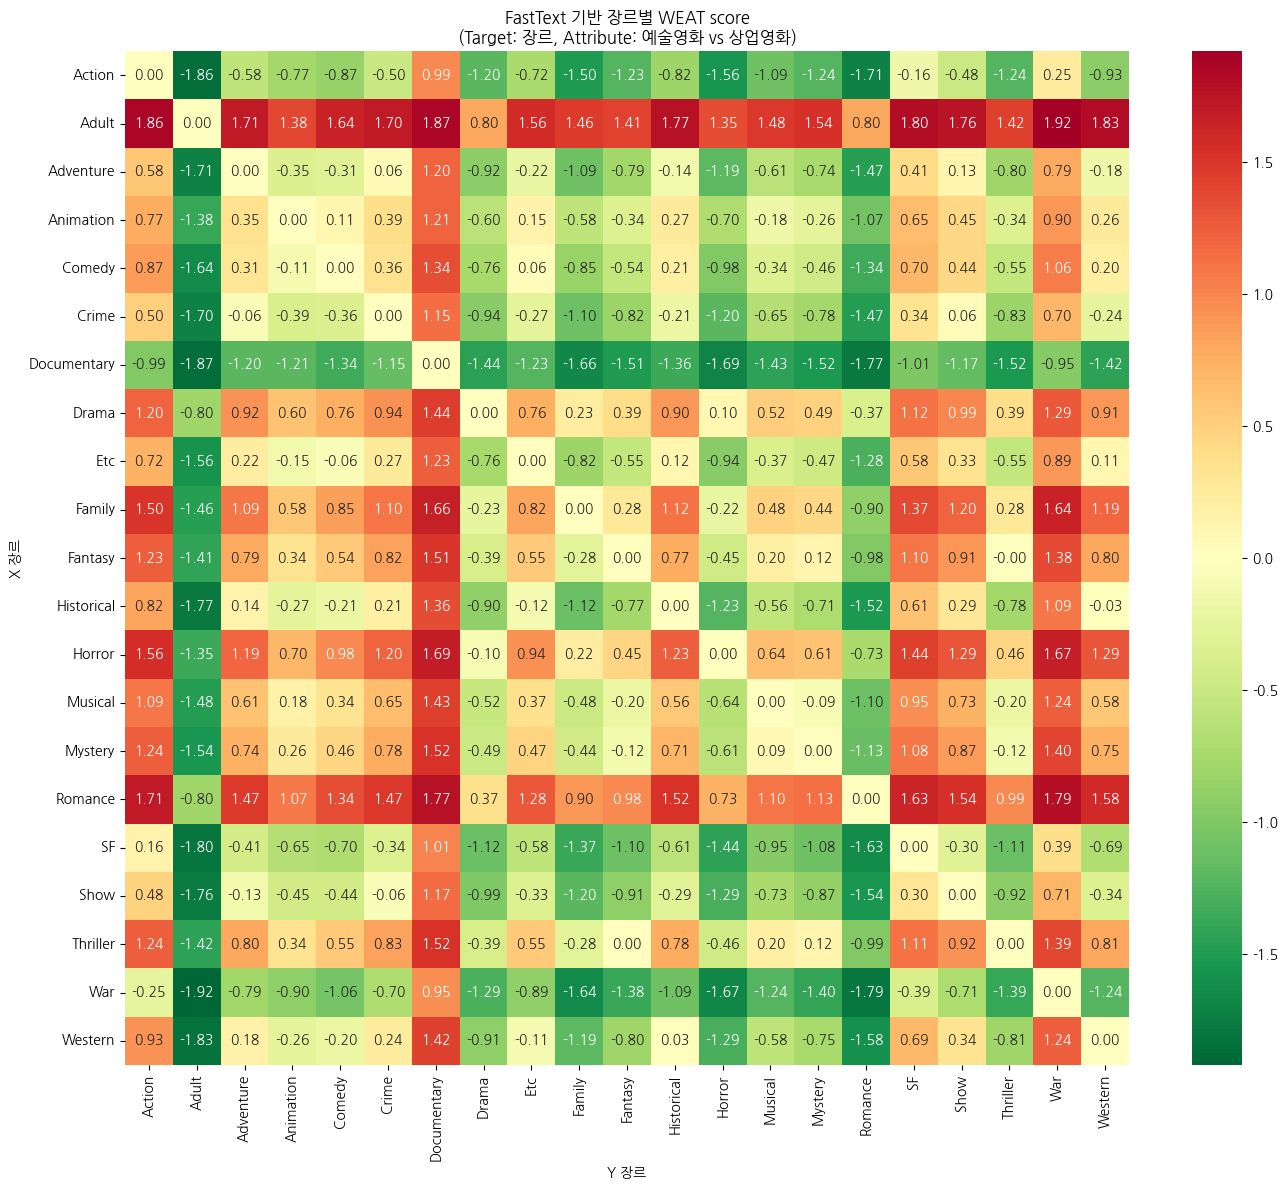

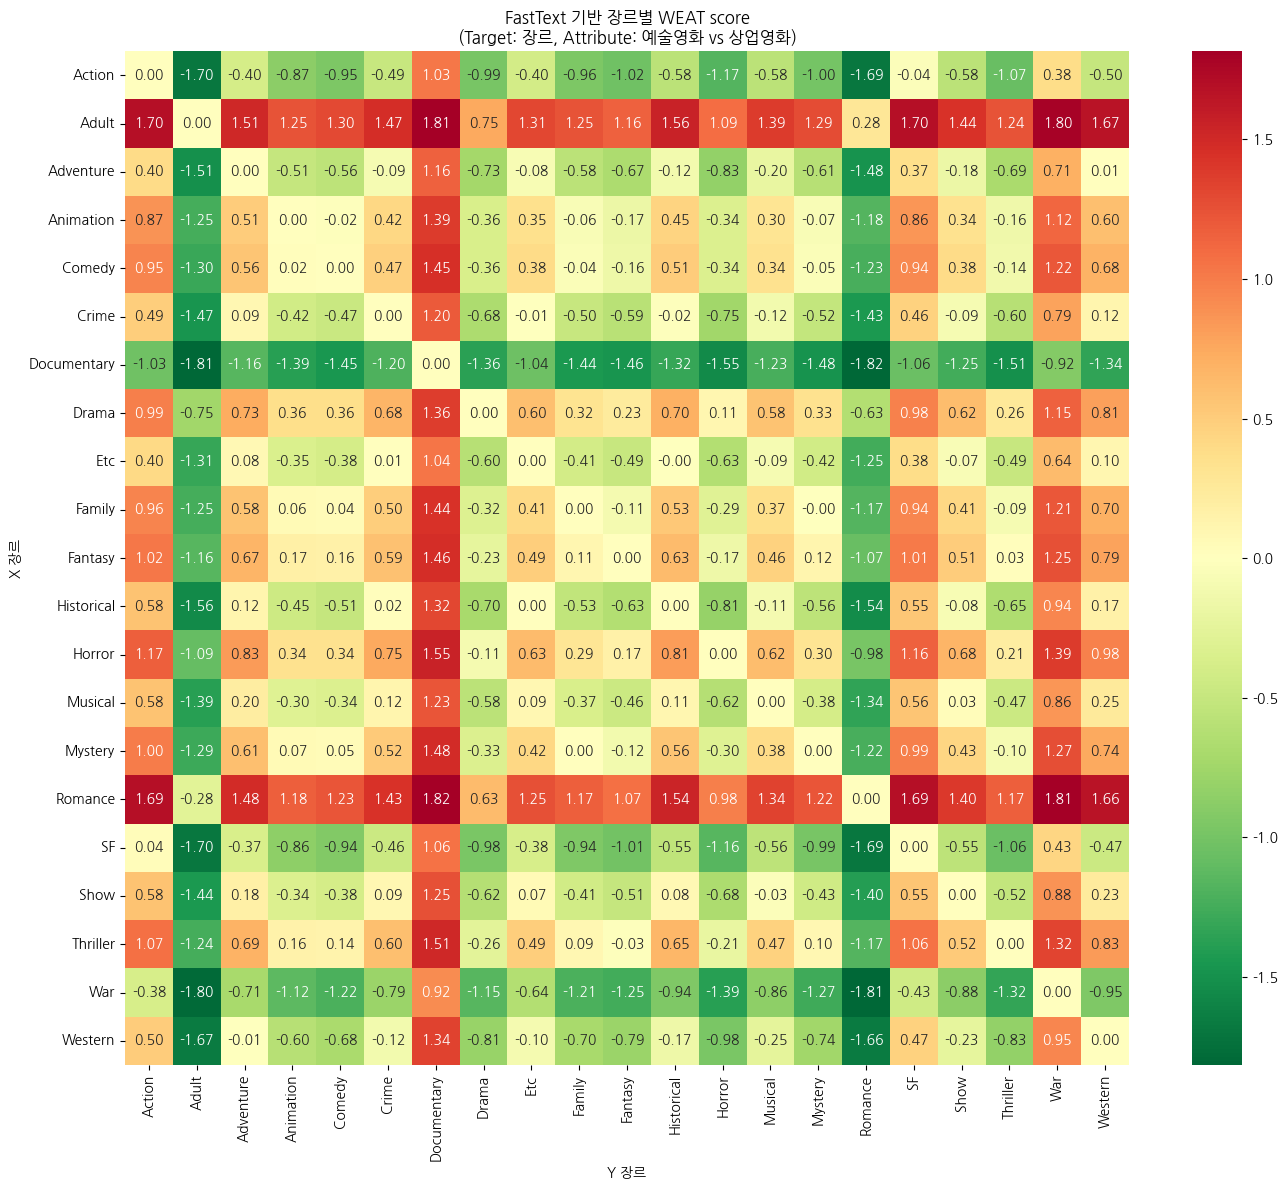

In [ ]:
threshold = 0.8
print(f"|score| >= {threshold} 인 장르 쌍만 출력\n")

for i in range(n_genre):
    for j in range(n_genre):
        if i == j:
            continue
        score = matrix[i, j]
        if abs(score) >= threshold:
            print(f"{genre_name[i]} vs {genre_name[j]}: {score:.2f}")


|score| >= 0.8 인 장르 쌍만 출력

Action vs Adult: -1.86
Action vs Comedy: -0.87
Action vs Documentary: 0.99
Action vs Drama: -1.20
Action vs Family: -1.50
Action vs Fantasy: -1.23
Action vs Historical: -0.82
Action vs Horror: -1.56
Action vs Musical: -1.09
Action vs Mystery: -1.24
Action vs Romance: -1.71
Action vs Thriller: -1.24
Action vs Western: -0.93
Adult vs Action: 1.86
Adult vs Adventure: 1.71
Adult vs Animation: 1.38
Adult vs Comedy: 1.64
Adult vs Crime: 1.70
Adult vs Documentary: 1.87
Adult vs Etc: 1.56
Adult vs Family: 1.46
Adult vs Fantasy: 1.41
Adult vs Historical: 1.77
Adult vs Horror: 1.35
Adult vs Musical: 1.48
Adult vs Mystery: 1.54
Adult vs Romance: 0.80
Adult vs SF: 1.80
Adult vs Show: 1.76
Adult vs Thriller: 1.42
Adult vs War: 1.92
Adult vs Western: 1.83
Adventure vs Adult: -1.71
Adventure vs Documentary: 1.20
Adventure vs Drama: -0.92
Adventure vs Family: -1.09
Adventure vs Horror: -1.19
Adventure vs Romance: -1.47
Animation vs Adult: -1.38
Animation vs Documentary: 1.21

[TRY 1]

Action vs Adult: -1.86
Action vs Comedy: -0.87
Action vs Documentary: 0.99
Action vs Drama: -1.20
Action vs Family: -1.50
Action vs Fantasy: -1.23
Action vs Historical: -0.82
Action vs Horror: -1.56
Action vs Musical: -1.09
Action vs Mystery: -1.24
Action vs Romance: -1.71
Action vs Thriller: -1.24
Action vs Western: -0.93
Adult vs Action: 1.86
Adult vs Adventure: 1.71
Adult vs Animation: 1.38
Adult vs Comedy: 1.64
Adult vs Crime: 1.70
Adult vs Documentary: 1.87
Adult vs Etc: 1.56
Adult vs Family: 1.46
Adult vs Fantasy: 1.41
Adult vs Historical: 1.77
Adult vs Horror: 1.35
Adult vs Musical: 1.48
Adult vs Mystery: 1.54
Adult vs Romance: 0.80
Adult vs SF: 1.80
Adult vs Show: 1.76
Adult vs Thriller: 1.42
Adult vs War: 1.92
Adult vs Western: 1.83
Adventure vs Adult: -1.71
Adventure vs Documentary: 1.20
Adventure vs Drama: -0.92
Adventure vs Family: -1.09
Adventure vs Horror: -1.19
Adventure vs Romance: -1.47
Animation vs Adult: -1.38
Animation vs Documentary: 1.21
Animation vs Romance: -1.07
Animation vs War: 0.90
Comedy vs Action: 0.87
Comedy vs Adult: -1.64
Comedy vs Documentary: 1.34
Comedy vs Family: -0.85
Comedy vs Horror: -0.98
Comedy vs Romance: -1.34
Comedy vs War: 1.06
Crime vs Adult: -1.70
Crime vs Documentary: 1.15
Crime vs Drama: -0.94
Crime vs Family: -1.10
Crime vs Fantasy: -0.82
Crime vs Horror: -1.20
Crime vs Romance: -1.47
Crime vs Thriller: -0.83
Documentary vs Action: -0.99
Documentary vs Adult: -1.87
Documentary vs Adventure: -1.20
Documentary vs Animation: -1.21
Documentary vs Comedy: -1.34
Documentary vs Crime: -1.15
Documentary vs Drama: -1.44
Documentary vs Etc: -1.23
Documentary vs Family: -1.66
Documentary vs Fantasy: -1.51
Documentary vs Historical: -1.36
Documentary vs Horror: -1.69
Documentary vs Musical: -1.43
Documentary vs Mystery: -1.52
Documentary vs Romance: -1.77
Documentary vs SF: -1.01
Documentary vs Show: -1.17
Documentary vs Thriller: -1.52
Documentary vs War: -0.95
Documentary vs Western: -1.42
Drama vs Action: 1.20
Drama vs Adventure: 0.92
Drama vs Crime: 0.94
Drama vs Documentary: 1.44
Drama vs Historical: 0.90
Drama vs SF: 1.12
Drama vs Show: 0.99
Drama vs War: 1.29
Drama vs Western: 0.91
Etc vs Adult: -1.56
Etc vs Documentary: 1.23
Etc vs Family: -0.82
Etc vs Horror: -0.94
Etc vs Romance: -1.28
Etc vs War: 0.89
Family vs Action: 1.50
Family vs Adult: -1.46
Family vs Adventure: 1.09
Family vs Comedy: 0.85
Family vs Crime: 1.10
Family vs Documentary: 1.66
Family vs Etc: 0.82
Family vs Historical: 1.12
Family vs Romance: -0.90
Family vs SF: 1.37
Family vs Show: 1.20
Family vs War: 1.64
Family vs Western: 1.19
Fantasy vs Action: 1.23
Fantasy vs Adult: -1.41
Fantasy vs Crime: 0.82
Fantasy vs Documentary: 1.51
Fantasy vs Romance: -0.98
Fantasy vs SF: 1.10
Fantasy vs Show: 0.91
Fantasy vs War: 1.38
Historical vs Action: 0.82
Historical vs Adult: -1.77
Historical vs Documentary: 1.36
Historical vs Drama: -0.90
Historical vs Family: -1.12
Historical vs Horror: -1.23
Historical vs Romance: -1.52
Historical vs War: 1.09
Horror vs Action: 1.56
Horror vs Adult: -1.35
Horror vs Adventure: 1.19
Horror vs Comedy: 0.98
Horror vs Crime: 1.20
Horror vs Documentary: 1.69
Horror vs Etc: 0.94
Horror vs Historical: 1.23
Horror vs SF: 1.44
Horror vs Show: 1.29
Horror vs War: 1.67
Horror vs Western: 1.29
Musical vs Action: 1.09
Musical vs Adult: -1.48
Musical vs Documentary: 1.43
Musical vs Romance: -1.10
Musical vs SF: 0.95
Musical vs War: 1.24
Mystery vs Action: 1.24
Mystery vs Adult: -1.54
Mystery vs Documentary: 1.52
Mystery vs Romance: -1.13
Mystery vs SF: 1.08
Mystery vs Show: 0.87
Mystery vs War: 1.40
Romance vs Action: 1.71
Romance vs Adult: -0.80
Romance vs Adventure: 1.47
Romance vs Animation: 1.07
Romance vs Comedy: 1.34
Romance vs Crime: 1.47
Romance vs Documentary: 1.77
Romance vs Etc: 1.28
Romance vs Family: 0.90
Romance vs Fantasy: 0.98
Romance vs Historical: 1.52
Romance vs Musical: 1.10
Romance vs Mystery: 1.13
Romance vs SF: 1.63
Romance vs Show: 1.54
Romance vs Thriller: 0.99
Romance vs War: 1.79
Romance vs Western: 1.58
SF vs Adult: -1.80
SF vs Documentary: 1.01
SF vs Drama: -1.12
SF vs Family: -1.37
SF vs Fantasy: -1.10
SF vs Horror: -1.44
SF vs Musical: -0.95
SF vs Mystery: -1.08
SF vs Romance: -1.63
SF vs Thriller: -1.11
Show vs Adult: -1.76
Show vs Documentary: 1.17
Show vs Drama: -0.99
Show vs Family: -1.20
Show vs Fantasy: -0.91
Show vs Horror: -1.29
Show vs Mystery: -0.87
Show vs Romance: -1.54
Show vs Thriller: -0.92
Thriller vs Action: 1.24
Thriller vs Adult: -1.42
Thriller vs Crime: 0.83
Thriller vs Documentary: 1.52
Thriller vs Romance: -0.99
Thriller vs SF: 1.11
Thriller vs Show: 0.92
Thriller vs War: 1.39
Thriller vs Western: 0.81
War vs Adult: -1.92
War vs Animation: -0.90
War vs Comedy: -1.06
War vs Documentary: 0.95
War vs Drama: -1.29
War vs Etc: -0.89
War vs Family: -1.64
War vs Fantasy: -1.38
War vs Historical: -1.09
War vs Horror: -1.67
War vs Musical: -1.24
War vs Mystery: -1.40
War vs Romance: -1.79
War vs Thriller: -1.39
War vs Western: -1.24
Western vs Action: 0.93
Western vs Adult: -1.83
Western vs Documentary: 1.42
Western vs Drama: -0.91
Western vs Family: -1.19
Western vs Horror: -1.29
Western vs Romance: -1.58
Western vs Thriller: -0.81
Western vs War: 1.24